### Questions

- What we have implemented now is a particle filter with a brdige proposal. This is different from the methods in the paper, since they use an MCMC step to sample from the bridge. Can we do this in `pfjax` easily?
- What are the importance weights when e use the MCMC step?


In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pfjax as pf
import pfjax.sde as sde

from functools import partial

import pfjax as pf
from pfjax import particle_resamplers as resampler

import time
from tqdm import tqdm

## Model

The Jump-Diffusion model is the following:

$$
\begin{aligned}
Z_{t+\Delta t} &= Z_t + (\theta + \kappa Z_t) \Delta t + \sigma_z \sqrt{Z_t} \Delta W_t^z + V_{t+\Delta t}^z J_{t+\Delta t} \\
X_{t+\Delta t} &= X_t + \alpha \Delta t + \sqrt{Z_t} \Delta W_t^x + V_{t+\Delta t}^x J_{t+\Delta t} 
\end{aligned}
$$

where

$$
\begin{aligned}
\Delta W_t^x, \Delta W_t^z &\sim \textrm{iid } N(0, \Delta t) \\
V_t^z &\sim \exp(\mu_z) \\
V_t^x &\sim N(\mu_x, \sigma^2_x) \\
J_{t+\Delta t} &\sim \textrm{Bern}(\lambda \Delta t).
\end{aligned}
$$

Thus, our parameters are $\Theta = (\alpha, \theta, \kappa, \sigma_z, \lambda,\mu_x, \sigma_x, \mu_z)$, observation is $X_t$ (the logarithm of asset price), and latent state $Z_t$ (unobserved volatility).

In [2]:
def euler_sim_jump(key, x, dt, drift_diff, jump, theta):
    """
    Simulate SDE with dense diffusion using Euler-Maruyama discretization.
    Args:
        key: PRNG key.
        x: Initial value of the SDE.  A vector of size `n_dims`.
        dt: Interobservation time.
        drift: Drift function having signature `drift(x, theta)` and returning a vector of size `n_dims`.
        diff: Diffusion function having signature `diff(x, theta)` and returning a vector of size `n_dims`.
        theta: Parameter value.
    Returns:
        Simulated SDE values. A vector of size `n_dims`.
    """
    _, diff_subkey, jump_subkey = random.split(key, 3)
    diff_process = drift_diff(diff_subkey, x, theta, dt)
    jump_process = jump(jump_subkey, x, theta, dt)
    return jnp.append(diff_process + jump_process, jump_process)

class SDEModel(object):
    
    def __init__(self, dt, n_res):
        self._dt = dt
        self._n_res = n_res
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_jump(key, x, dt, self.drift_diff, self.jump, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        def fun(carry, t):
            key, subkey = random.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full
    
    def is_valid_state(self, x, theta):
        return not jnp.sum(x < 0) > 0

In [3]:
class JumpDiff(SDEModel):
    
    def __init__(self, dt, n_res, bootstrap=False):
        super().__init__(dt, n_res)
        self._n_state = (self._n_res, 4)
        
    def drift(self, x, theta):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        return mu
    
    def diff(self, x, theta):
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        diff_process = jax.random.multivariate_normal(key, mean= x[:2] + mu*dt, cov=Sigma*dt)
        return diff_process
    
    def jump(self, key, x, theta, dt):
        keys = random.split(key, 3)
        is_jump = jax.random.bernoulli(keys[0,], p=theta[4]*dt)
        jump_process = jnp.where(is_jump==1.0, 
                                 jnp.array([theta[7]*jax.random.exponential(keys[1,]), 
                                            theta[5] + theta[6]*jax.random.normal(keys[2,])]),
                                 jnp.array([0.0,0.0]))
        return jump_process
    
    def get_x(self, x):
        X = x[:2]
        jump = x[2:]
        return X, jump
    
    def meas_sample(self, key, x_curr, theta):
        return x_curr[-1][1]
    
    def state_lpdf(self, x_curr, x_prev, theta):
        r"""
        Sample from Euler transition density: `p(x_curr | x_prev, theta)`
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + drift(x_prev, theta)[1]*dt + x_curr[3],
                scale=jnp.sqrt(diff(x_prev, theta)[1,1]*dt)
            ) 
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          drift=self.drift,
                          diff=self.diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def _state_lpdf_for(self, x_curr, x_prev, theta):
        dt_res = self._dt/self._n_res
        x0 = jnp.append(jnp.expand_dims(
            x_prev[self._n_res-1], axis=0), x_curr[:self._n_res-1], axis=0)
        x1 = x_curr
        lp = jnp.array(0.0)
        
        for t in range(self._n_res):
            lp = lp + jnp.sum(jsp.stats.norm.logpdf(
                x=x1[t][1],
                loc=x0[t][1] + self.drift(x0[t], theta)[1]*dt_res + x1[t][3],
                scale=jnp.sqrt(self.diff(x0[t], theta)[1,1]*dt_res)
            ))
        return lp
    
    def _bridge_param(self, x, y_curr, theta, n, vz, vx, vx_invcumsum):
        k = self._n_res - n
        dt_res = self._dt/self._n_res

        mu_z = x[0] + (theta[1]+theta[2]*x[0])*dt_res + vz
        sig2_z = x[0]*(theta[3]**2)*dt_res

        mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
        sig2_x = (k - 1)/k*x[0]*dt_res

        return mu_z, sig2_z, mu_x, sig2_x
    
    def pf_step(self, key, x_prev, y_curr, theta):
        
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)

        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]

            n, vz, vx, vx_invcumsum = t
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum)

            key, z_subkey, x_subkey = random.split(key,3)

            x_prop = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                jnp.where(n<self._n_res-1, 
                                          mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                          y_curr),
                                vz, vx])

            lp_prop = jnp.where(n<self._n_res-1,
                                jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                                0.0)

            res_carry = {
                "x": x_prop,
                "key": key,
                "lp": carry["lp"] + lp_prop
            }

            res_stack = {"x": x_prop, "lp": lp_prop}

            return res_carry, res_stack

        scan_init = {
            "x": x_prev[self._n_res-1],
            "key": key,
            "lp": jnp.array(0.)
        }
        
        ns = jnp.arange(self._n_res)
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta[4]*self._dt/self._n_res)
        vzs = theta[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta[5]+theta[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]

        last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum))
        x_prop = full["x"]
        logw_trans = self.state_lpdf(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )

        logw = logw_trans - last["lp"]
        return x_prop, logw
    
    def _pf_step_for(self, key, x_prev, y_curr, theta):
        dt_res = self._dt/self._n_res
        x_curr = []
        x_state = x_prev[self._n_res-1]
        lp = jnp.array(0.0)
        
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)
        
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta[4]*self._dt/self._n_res)
        vzs = theta[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta[5]+theta[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
        
        for t in range(self._n_res):
            key, z_subkey, x_subkey = random.split(key,3)
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x_state, y_curr, theta, t, 
                                                            vzs[t], vxs[t], vxs_invcumsum[t])
            
            x_state = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                 jnp.where(t<self._n_res-1, 
                                           mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                           y_curr),
                                 vzs[t], vxs[t]])

            lp_prop = jnp.where(t<self._n_res-1,
                           jsp.stats.norm.logpdf(x=x_state[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                           0.0)
            
            x_curr.append(x_state)
            lp = lp + lp_prop
        
        x_prop = jnp.array(x_curr)
        
        logw_trans = self._state_lpdf_for(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )
        
        logw = logw_trans - lp
        
        return x_prop, logw
    
    def pf_init(self, key, y_init, theta):
        key, subkey = random.split(key)
        x_init = y_init + 5*random.normal(
            subkey
        )
        z_init = random.truncated_normal(
            subkey,
            lower=0.5,
            upper=10)
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init, 0.0, 0.0]), axis = 0), axis=0), \
            logw

In [4]:
key = random.PRNGKey(0)

_dt = 1
_n_res = 5
n_obs = 3000

# parameters: 
alpha = 0.08
_theta = 0.02
kappa = -0.03
sigma_z = 0.12
gamma = 0.01
mu_x = -3.1
sigma_x = 2.7
mu_z = 1.7

theta = jnp.array([alpha, _theta, kappa, sigma_z, gamma, mu_x, sigma_x, mu_z])
x_init = jnp.block([[jnp.zeros((_n_res-1, 4))],
                    [jnp.array([2.0, 50.0, 0, 0])]])

jdmodel = JumpDiff(_dt, _n_res)

In [5]:
y_meas, x_state = pf.simulate(jdmodel, key, n_obs, x_init, theta)

point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * _n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

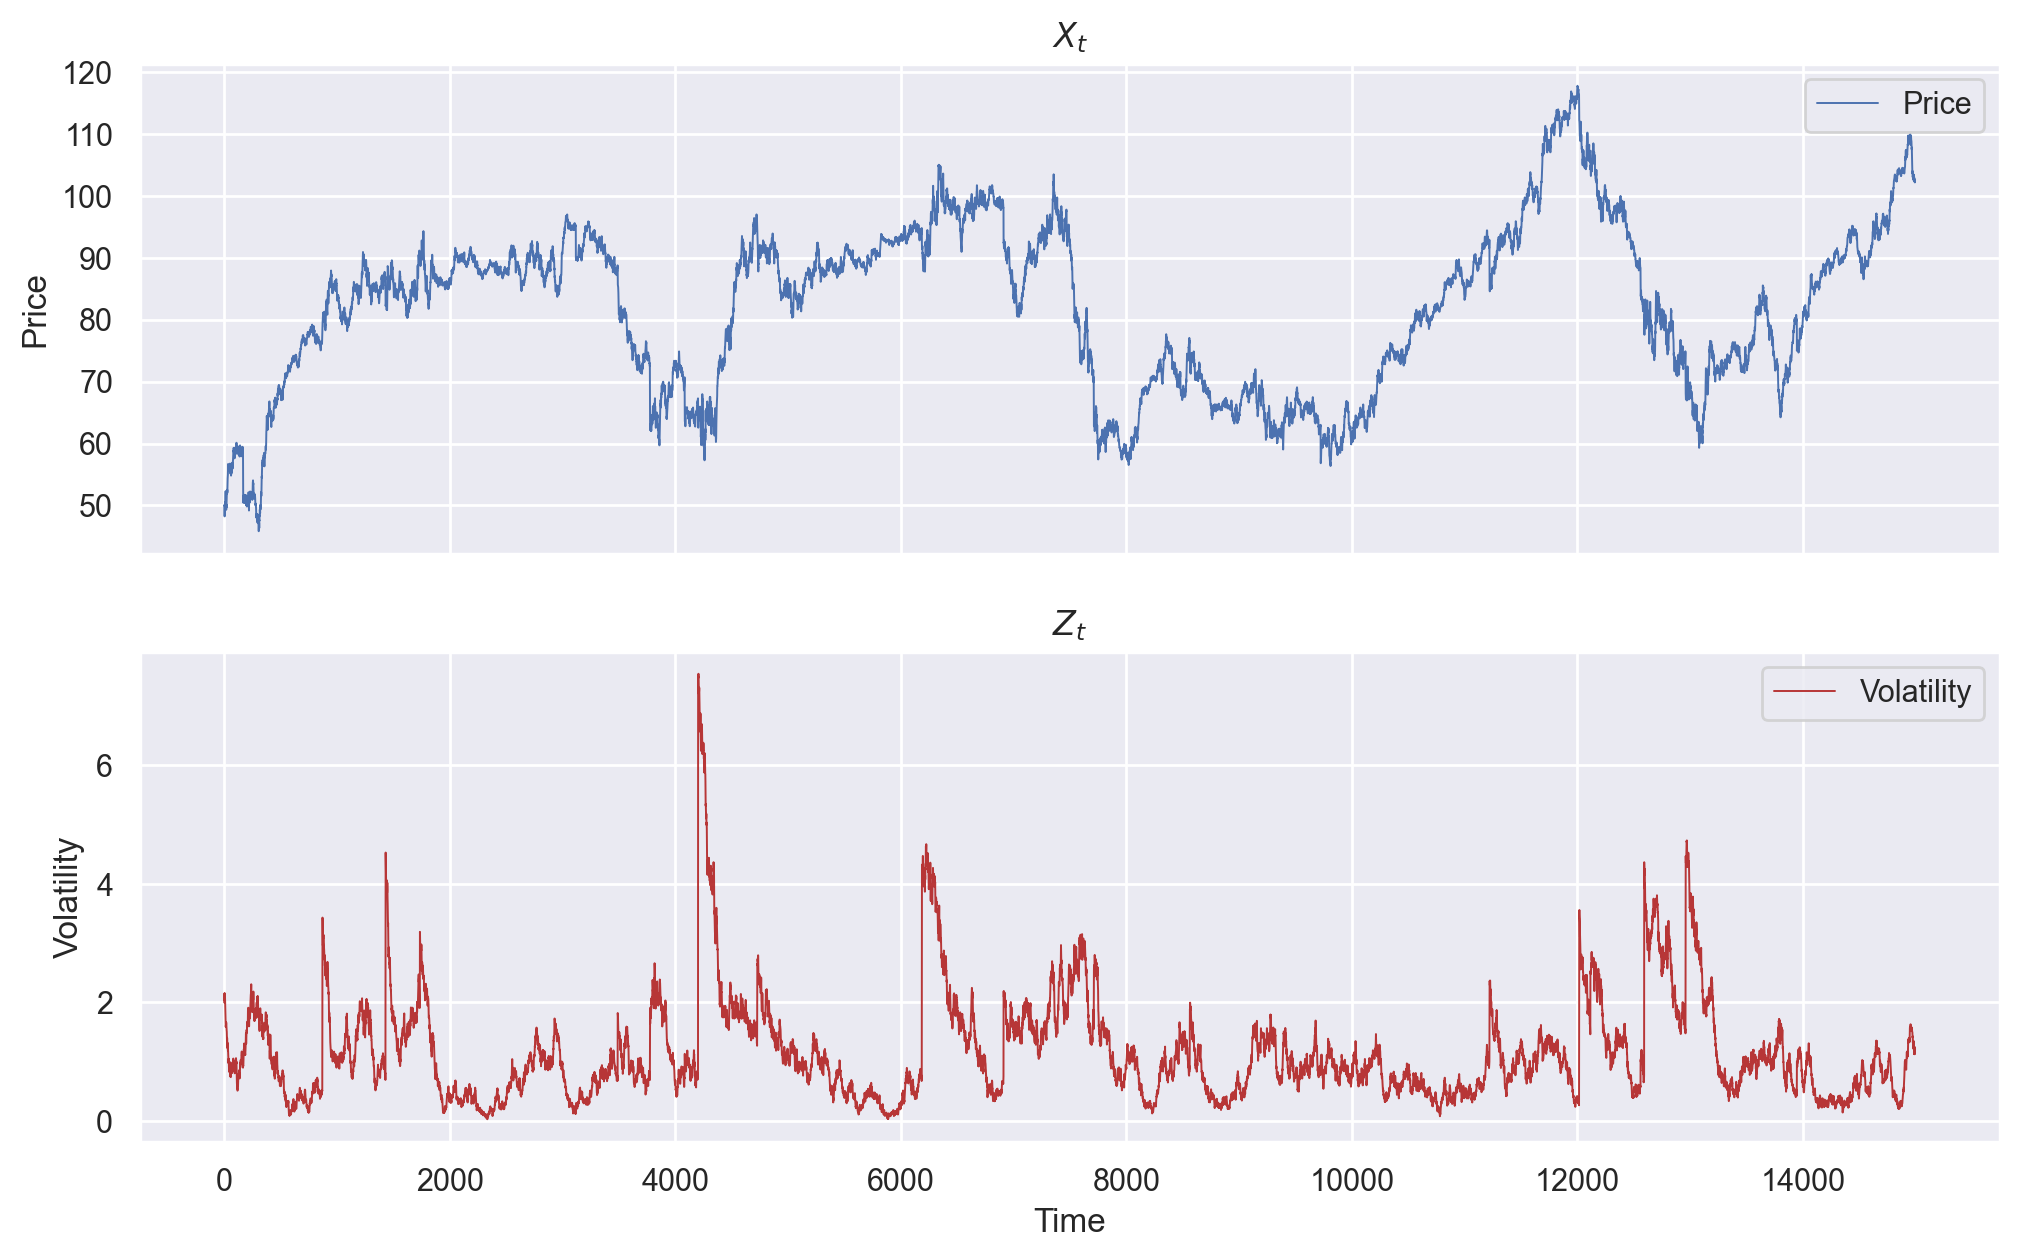

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(_n_res*n_obs, 1)[(_n_res-1):].squeeze(),
             ax = ax[0], linewidth=0.7,
             label = "Price").set(title ="$X_t$", ylabel="Price")
# sns.scatterplot(x = "Time", y = "Log Asset Price", 
#                 data = point_plot,
#                 color = "firebrick",
#                 ax = ax[0],
#                 s=5,
#                 label="Observed").set(title ="$X_t$")
# sns.lineplot(data= x_state[..., 3].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze() + y_meas[0],
#              ax = ax[0], alpha = 0.9, linewidth=0.7,
#              label = "Price jumps");

sns.lineplot(data= x_state[..., 0].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
             ax = ax[1], alpha = 0.9, linewidth=0.7, color = "firebrick",
             label = "Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");
# sns.lineplot(data= x_state[..., 2].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
#              ax = ax[1], alpha = 0.9, linewidth=0.7,
#              label = "Vol jumps");

In [7]:
x_curr = x_state[2,:,:]
x_prev = x_state[1,:,:]
y_curr = x_prev[_n_res][1]

print("pf_step JAX: ", jdmodel.pf_step(key, x_prev, y_curr, theta))
print("pf_step for-loop: ", jdmodel._pf_step_for(key, x_prev, y_curr, theta))

pf_step JAX:  (DeviceArray([[ 2.065472 , 48.70711  ,  0.       ,  0.       ],
             [ 1.9936337, 48.776    ,  0.       ,  0.       ],
             [ 2.0499337, 48.671814 ,  0.       ,  0.       ],
             [ 2.0241783, 48.70818  ,  0.       ,  0.       ],
             [ 1.9588809, 48.80784  ,  0.       ,  0.       ]],            dtype=float32), DeviceArray(-1.2729524, dtype=float32))
pf_step for-loop:  (DeviceArray([[ 2.065472 , 48.70711  ,  0.       ,  0.       ],
             [ 1.9936337, 48.776    ,  0.       ,  0.       ],
             [ 2.0499337, 48.671814 ,  0.       ,  0.       ],
             [ 2.0241783, 48.70818  ,  0.       ,  0.       ],
             [ 1.9588809, 48.80784  ,  0.       ,  0.       ]],            dtype=float32), DeviceArray(-1.2729524, dtype=float32))


In [8]:
print("lpdf JAX: ", jdmodel.state_lpdf(x_curr, x_prev, theta))
print("lpdf for: ", jdmodel._state_lpdf_for(x_curr, x_prev, theta))

lpdf JAX:  -4.7876163
lpdf for:  -4.7876163


## `pfjax` PF

In [63]:
def plot_particles (x_state, y_meas, vol_particles, price_particles, title="", plot_res=True):
    n_res = _n_res
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex = True)
    fig.suptitle(title)

    sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
                 ax = ax[0], linewidth = 0.7,
                 label = "Latent")
    sns.scatterplot(x = "Time", y = "Log Asset Price", 
                    data = point_plot,
                    color = "firebrick",
                    ax = ax[0],
                    label="Observed").set(xlabel="Time",title ="$X_t$");

    sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
                 ax = ax[1], linewidth = 0.7,
                 label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility")
    if plot_res:
        for t in range(n_obs-1):
            for s in range(n_res):
                my_x = (t*n_res) + s
                sns.scatterplot(x = my_x, 
                                y=price_particles[t, :, s], 
                                s = 2, alpha = 0.5,
                                color = "green", ax = ax[0]);
                sns.scatterplot(x = my_x, 
                                y=vol_particles[t, :, s], 
                                s = 2, alpha = 0.5,
                                color = "green", ax = ax[1]);
    else:
        for t in range(n_obs-1):
            sns.scatterplot(x = t*n_res, 
                            y=price_particles[t, :, n_res-2], 
                            s = 2, alpha = 0.5,
                            color = "green", ax = ax[0]);
            sns.scatterplot(x = t*n_res, 
                            y=vol_particles[t, :, n_res-2], 
                            s = 2, alpha = 0.5,
                            color = "green", ax = ax[1]);
            
            
def jittered_multinomial(key, x_particles_prev, logw, h):
    r"""
    Variant of the resampling function presented in: 
    https://www.tandfonline.com/doi/abs/10.1198/jcgs.2009.07137
    
    They jitter each particle with N(0, h^2 B). However it is not clear how B is selected.
    I have selected the kernel bandwidth here, h, as 1/num_particles
    """
    prob = pf.utils.logw_to_prob(logw)
    n_particles = logw.size
    ancestors = random.choice(key,
                              a=jnp.arange(n_particles),
                              shape=(n_particles,), p=prob)
    jitter = random.normal(key, shape = x_particles_prev.shape) * h
    return {
        "x_particles": x_particles_prev[ancestors, ...] + jitter,
        "ancestors": ancestors
    }


def rmse (x, y):
    """ Find RMSE between x and y """
    return jnp.sqrt(jnp.mean((x-y)**2))


def quantile_index (logw, q):
    """
    Returns the index of the q-th quantile of logw
    """
    w = pf.utils.logw_to_prob(logw)
    val = jnp.quantile(w, q=q)
    nearest_ind = jnp.argmin(jnp.abs(val - w)) # find index of closest point to val
    return nearest_ind

In [64]:
num_particles = 30_000
resample_jittered_multinomial = partial(
    jittered_multinomial,
    h=1/(num_particles*5)
)

pf_jit = jax.jit(partial(
    pf.particle_filter,
    model = jdmodel,
    key = random.PRNGKey(0),
    y_meas = y_meas,
    theta = theta,
    resampler = resample_jittered_multinomial,
    history=True
), static_argnames="n_particles")

multinom_pf = pf_jit(n_particles=num_particles)

In [79]:
est_vol_mean = jax.vmap(
    lambda x, w: jnp.average(x, axis=0, weights=pf.utils.logw_to_prob(w)),
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

est_vol_lower = jax.vmap(
    lambda x, logw: x[quantile_index(logw, q=0.025)],
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

est_vol_upper = jax.vmap(
    lambda x, logw: x[quantile_index(logw, q=0.975)],
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

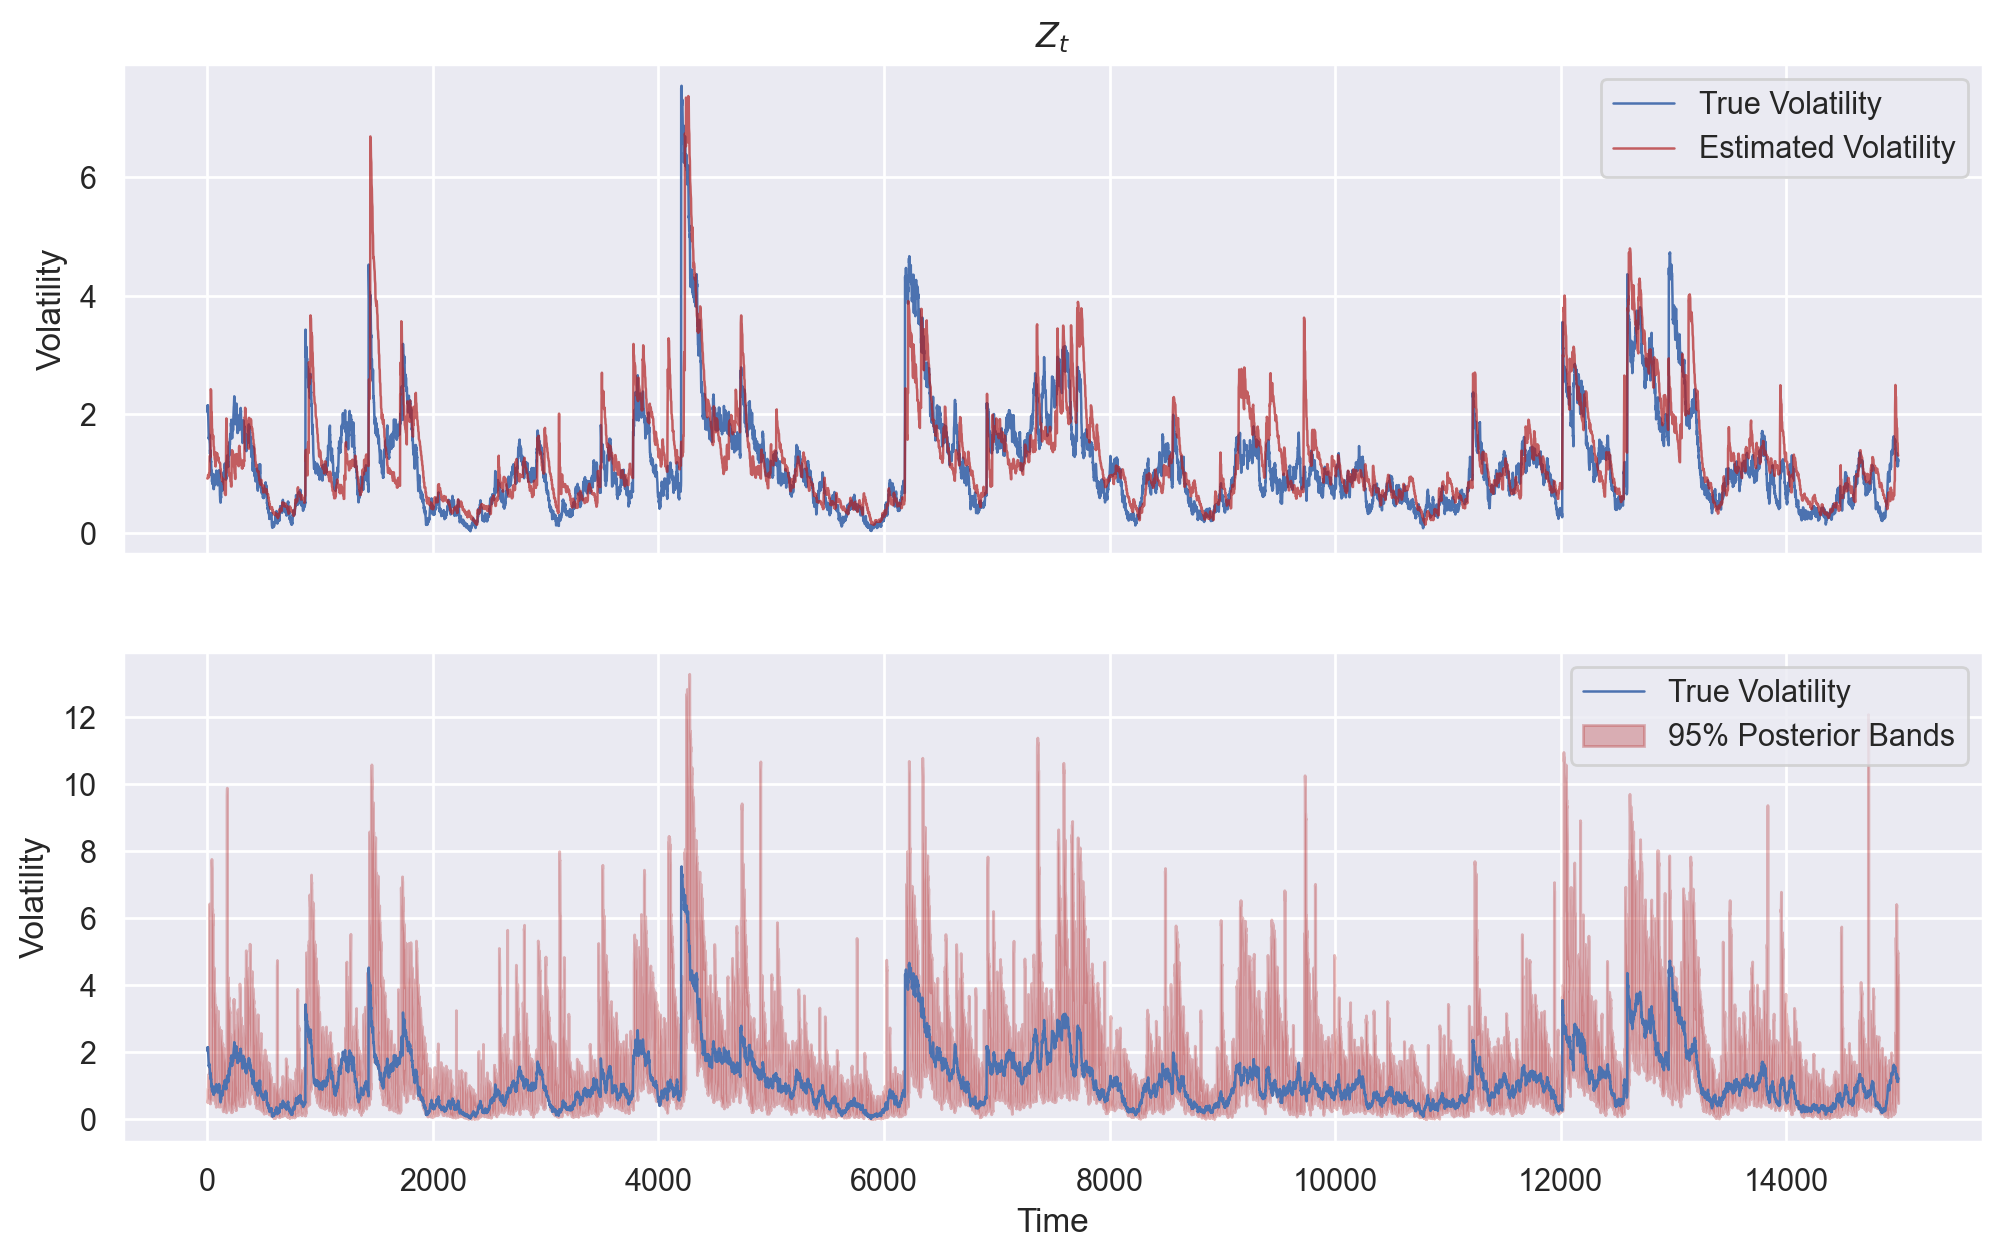

In [81]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(
    data = x_state[1:, :, 0].flatten(),
    linewidth = 0.9, ax=ax[0],
    label = "True Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility")
sns.lineplot(data = est_vol_mean.flatten(), 
             color = "firebrick", linewidth = 0.9, 
             alpha = 0.7, ax=ax[0],
             label = "Estimated Volatility")

sns.lineplot(
    data = x_state[1:, :, 0].flatten(), ax=ax[1],
    linewidth=0.9, 
    label = "True Volatility").set(xlabel="Time", ylabel="Volatility")
ax[1].fill_between(
    x = jnp.arange((n_obs-1)*_n_res),
    y1=est_vol_lower.flatten(),
    y2=est_vol_upper.flatten(),
    color = "firebrick",
    label="95% Posterior Bands",
    alpha = 0.3
)
ax[1].legend();

In [80]:
rmse(est_vol_mean.flatten(), x_state[1:, :, 0].flatten())

DeviceArray(0.59808177, dtype=float32)

In [62]:
plot_particles(x_state, y_meas, 
               vol_particles=multinom_pf["x_particles"][1:, :, :, 0], 
               price_particles=multinom_pf["x_particles"][1:, :, :, 1],
               plot_res=False,
               title = "Filtering of Jump Diffusion")

## S&P 500 Index Data

In [83]:
import yfinance as yf

snp_data = yf.download('^GSPC','1986-01-03','2000-01-03')
snp_closing = jnp.array(snp_data["Adj Close"])
snp_log_closing = jnp.log(snp_closing)

[*********************100%***********************]  1 of 1 completed


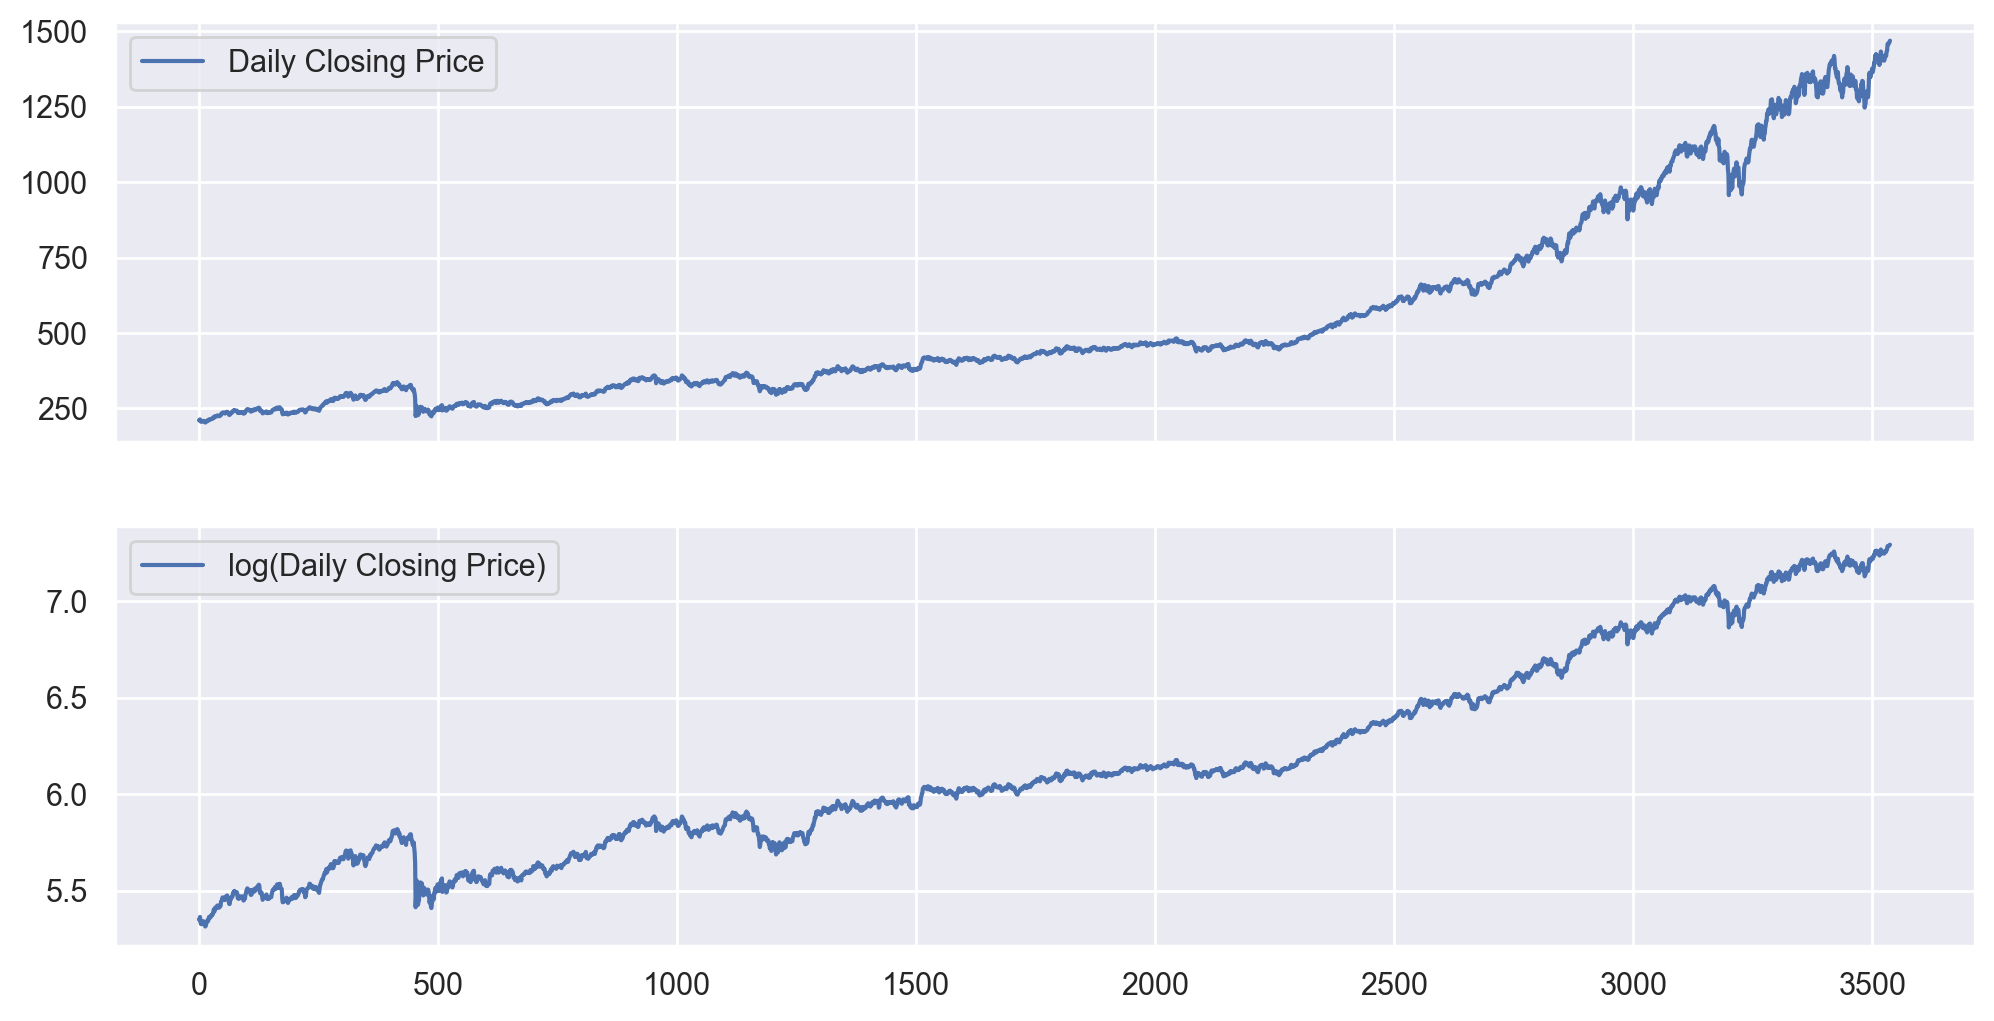

In [88]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex = True)
# fig.suptitle("S&P 500 Daily Closing Prices: Jan 1986 - Jan 2000")
sns.lineplot(snp_closing, ax = ax[0], label = "Daily Closing Price")
sns.lineplot(snp_log_closing, ax = ax[1], label = "log(Daily Closing Price)");

In [105]:
snp_theta = jnp.array([0.076, 0.018, -0.03, 0.007, -3.175, 2.595, 1.489])
snp_jdmodel = JumpDiff(dt=1, n_res=5)

snp_pf = jax.jit(partial(
    pf.particle_filter,
    model = snp_jdmodel,
    key = random.PRNGKey(0),
    y_meas = snp_log_closing,
    theta = theta,
    resampler = resample_jittered_multinomial,
    history = True
), static_argnames="n_particles")

start = time.perf_counter()
snp_filtered = snp_pf(n_particles = num_particles)
print("Time: ", time.perf_counter() - start)

Time:  272.2884218440013


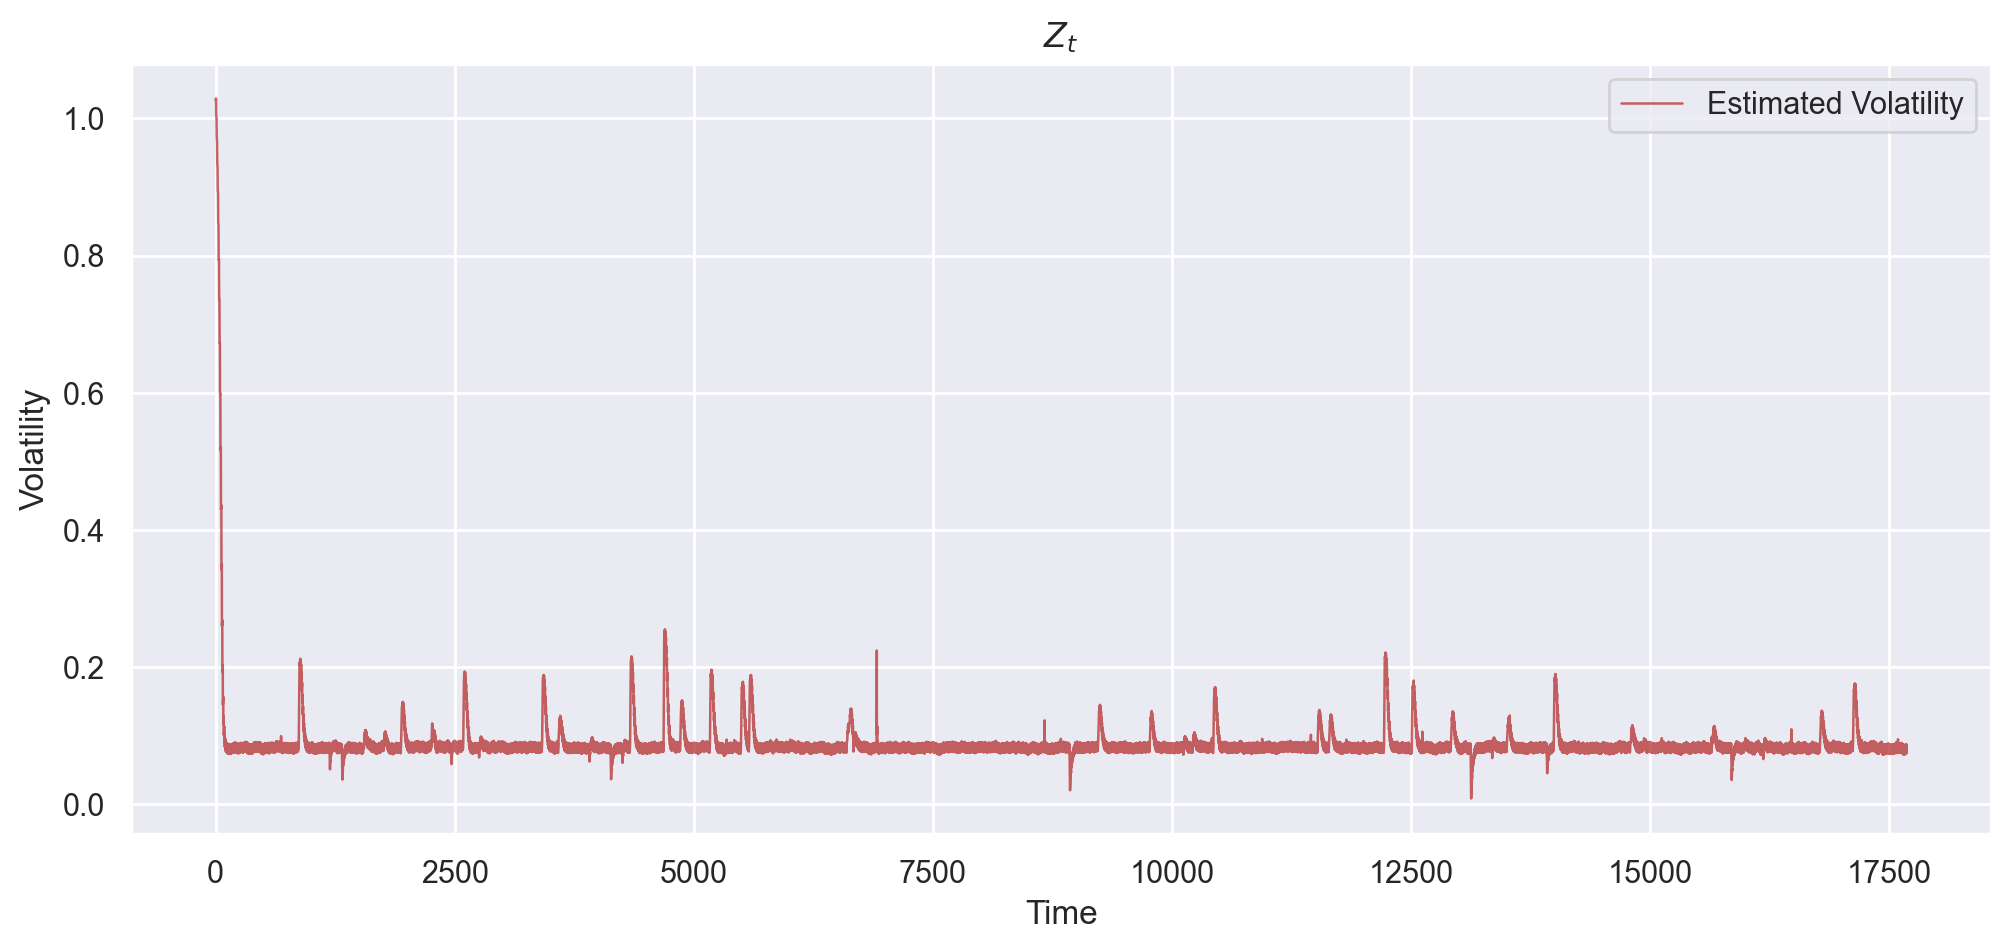

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharex = True)

est_vol_mean = jax.vmap(
    lambda x, w: jnp.average(x, axis=0, weights=pf.utils.logw_to_prob(w)),
    in_axes = (0, 0))(snp_filtered["x_particles"][1:, ..., 0],
                      snp_filtered["logw"][1:, ...])

sns.lineplot(data = est_vol_mean.flatten(), 
             color = "firebrick", linewidth = 0.9, 
             alpha = 0.7, ax=ax,
             label = "Estimated Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

In [113]:
snp_theta = jnp.array([0.076, 0.018, -0.03, 0.007, -3.175, 2.595, 1.489])
snp_jdmodel = JumpDiff(dt=1, n_res=5)

snp_pf = jax.jit(partial(
    pf.particle_filter,
    model = snp_jdmodel,
    key = random.PRNGKey(0),
    y_meas = snp_closing,
    theta = snp_theta,
    resampler = resample_jittered_multinomial,
    history = True
), static_argnames="n_particles")

start = time.perf_counter()
snp_filtered = snp_pf(n_particles = num_particles)
print("Time: ", time.perf_counter() - start)

Time:  234.18405427200014


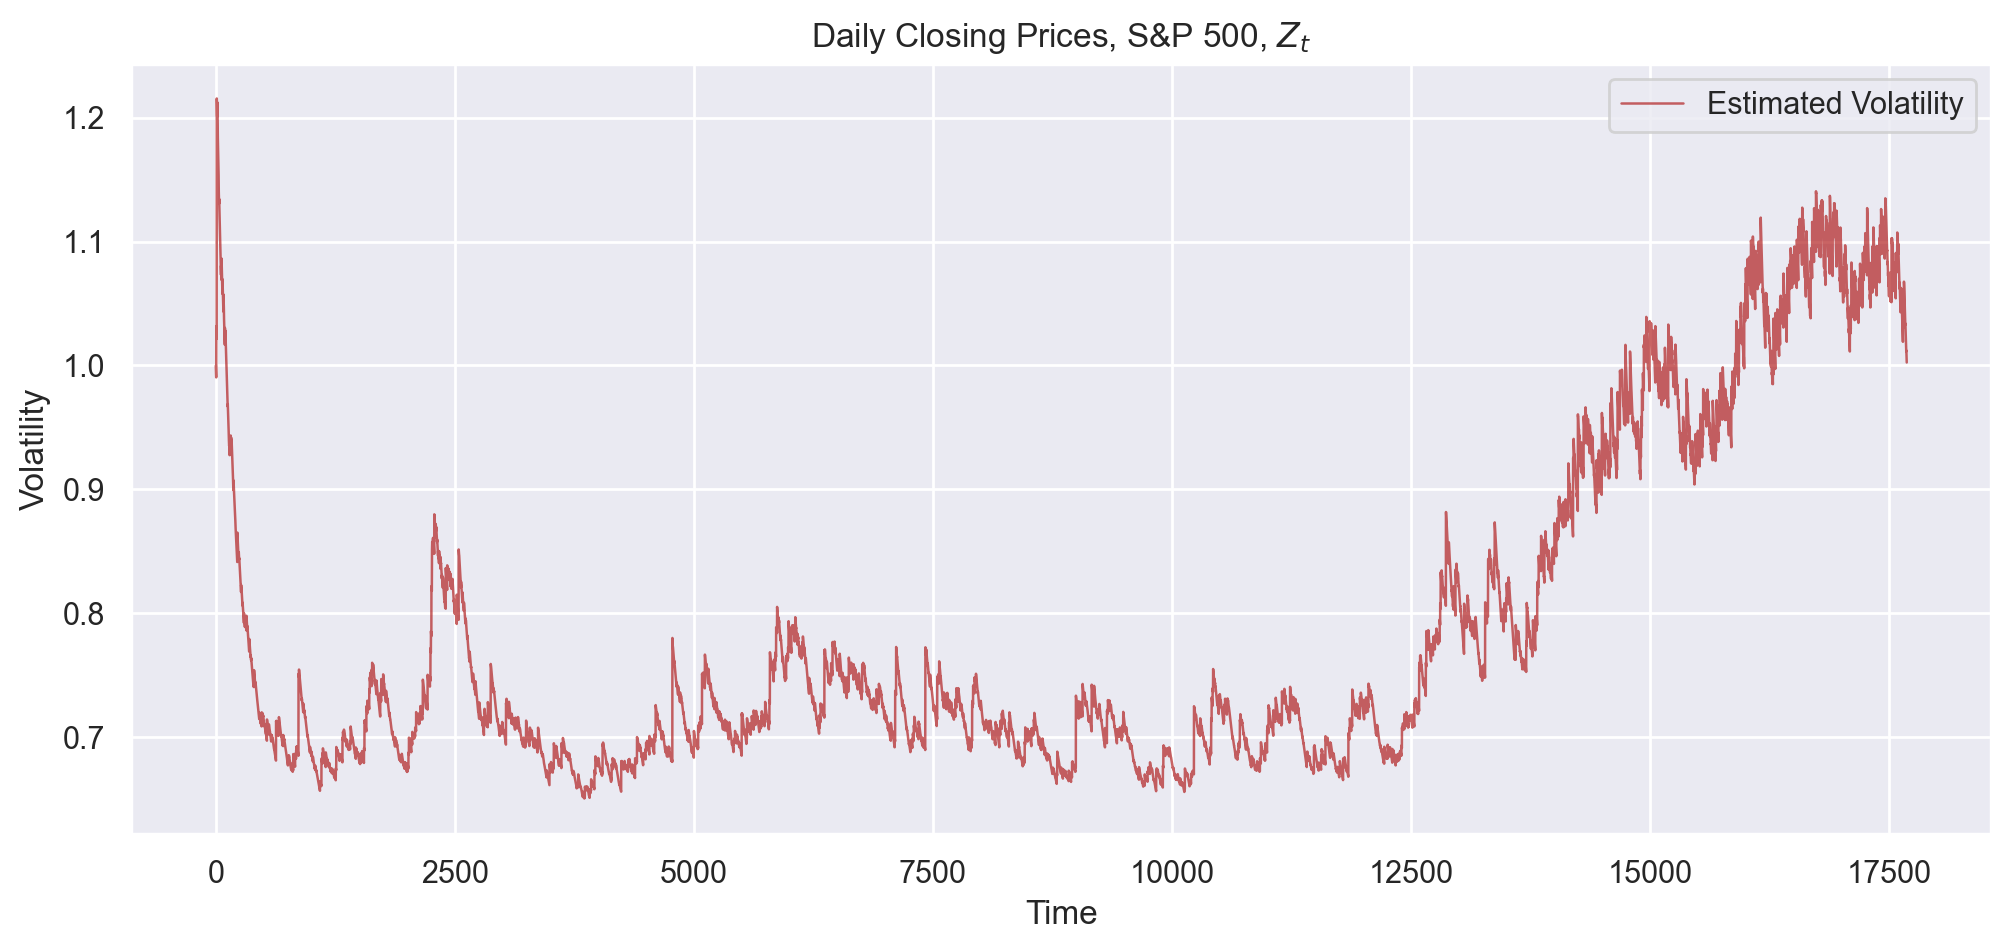

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharex = True)

est_vol_mean = jax.vmap(
    lambda x, w: jnp.average(x, axis=0, weights=pf.utils.logw_to_prob(w)),
    in_axes = (0, 0))(snp_filtered["x_particles"][1:, ..., 0],
                      snp_filtered["logw"][1:, ...])

sns.lineplot(data = est_vol_mean.flatten(), 
             color = "firebrick", linewidth = 0.9, 
             alpha = 0.7, ax=ax,
             label = "Estimated Volatility").set(xlabel="Time",title = "Daily Closing Prices, S&P 500, $Z_t$", 
                                                 ylabel="Volatility");

## Particle Filter - `for`

`for` loop version of the particle filter used for testing

In [ ]:
# def particle_filter_for(y_meas, theta, n_particles, key):
def particle_filter_for (model, key, y_meas, theta, n_particles, for_loop=False):
    r"""
    Implementation of the particle filter in Algorithm 1 of Stat 906 project writeup
    """
    n_obs = y_meas.shape[0]
    key, *subkeys = random.split(key, num=n_particles+1)
    x_particles = jnp.zeros((n_particles, *model._n_state))
    logw = jnp.zeros(n_particles)

    # initial particles and weights
    for i, _subkey in enumerate(subkeys):
        init_tmp = model.pf_init(key=_subkey, y_init=y_meas[0], theta=theta)
        x_particles = x_particles.at[i].set(init_tmp[0])
        logw = logw.at[i].set(init_tmp[1])

    # start particle filter: 
    all_particles = jnp.zeros((n_obs, *x_particles.shape))
    all_particles = all_particles.at[0].set(x_particles)
    all_logw = logw
    loglik = jsp.special.logsumexp(logw)
    for t in jnp.arange(1, n_obs):
        key, subkey = random.split(key)

        # resample particles
        resample_out = resampler.resample_multinomial(
            key=subkey,
            x_particles_prev=x_particles,
            logw=logw
        )

        # sample particles for current timepoint
        key, *subkeys = random.split(key, num=n_particles+1)
        x_particles, logw = jax.vmap(
            lambda k, x, y: model.pf_step(key=k, x_prev=x, y_curr=y, theta=theta),
            in_axes=(0, 0, None)
        )(jnp.array(subkeys), resample_out["x_particles"], y_meas[t])
        
        loglik += jsp.special.logsumexp(logw) # log-likelihood calculation
        all_particles = all_particles.at[t].set(x_particles)
        all_logw = all_logw.at[t].set(logw)
    
    return {
        "x_particles": all_particles,
        "logw": all_logw,
        "loglik": loglik - n_obs * jnp.log(n_particles)
    }

In [ ]:
start = time.perf_counter()
jd_for = particle_filter_for(
    model = jdmodel,
    key = random.PRNGKey(0),
    y_meas = y_meas,
    theta = theta,
    n_particles = num_particles
)
print("Time: ", time.perf_counter() - start)

In [ ]:
start = time.perf_counter()
multinom_pf = pf.particle_filter(
    theta=theta, 
    model=jdmodel, 
    y_meas=y_meas, 
    n_particles=num_particles, 
    key=random.PRNGKey(0),
    history = True)
print("Time: ", time.perf_counter() - start)

In [ ]:
print("for-loop loglik: ", jd_for["loglik"])
print("JAX loglik: ", multinom_pf["loglik"])

# Simulations

We will run simulations to test the difference in runtime between JIT VS non-JIT VS non-JAX particle filter for the following settings: 

- Different number of particles
- Different resolution numbers, $m$

### Number of Particles

In [ ]:
def pf_timer (pf_method, n_particles_list, n_sim=15):
    r"""
    Function for recording the runtime of different particle filters for a given number of particles. Each
    setting of n_particles_list is evaluated n_sim times
    
    Args: 
        - pf_method: Partial function accepting n_particles and running the particle filter one time
        - n_particles_list: list of number of particles to evaluate the particle filter with
    
    Returns: 
        - adlfkj
    """
    all_times = jnp.zeros((len(n_particles_list), n_sim))
    all_loglik = jnp.zeros((len(n_particles_list), n_sim))
    for i, n_particles in tqdm(enumerate(n_particles_list)):
        for sim_number in range(n_sim):
            start = time.perf_counter()
            loglik = pf_method(n_particles=n_particles)
            end = time.perf_counter()
            all_times = all_times.at[i, sim_number].set(end - start) # record runtime 
            all_loglik = all_loglik.at[i, sim_number].set(loglik["loglik"]) # record loglik for my sanity
    return {
        "all_times": all_times,
        "all_loglik": all_loglik,
        "avg_times": all_times.mean(axis = 1)
    }

In [ ]:
non_jax_pf = partial(
    particle_filter_for,
    model = jdmodel,
    key = random.PRNGKey(0),
    y_meas = y_meas,
    theta = theta   
)

non_jit_pf = partial(
    pf.particle_filter,
    model = jdmodel,
    key = random.PRNGKey(0),
    y_meas = y_meas,
    theta = theta   
)

jit_pf = jax.jit(partial(
    pf.particle_filter,
    model = jdmodel,
    key = random.PRNGKey(0),
    y_meas = y_meas,
    theta = theta,
), static_argnames="n_particles")

In [ ]:
num_particle_list = [50, 100, 250, 500]
non_jax_info = pf_timer(non_jax_pf, num_particle_list, n_sim=3)
non_jit_info = pf_timer(non_jit_pf, num_particle_list, n_sim=15)
jit_info = pf_timer(jit_pf, num_particle_list, n_sim=15)

In [ ]:
sns.lineplot(x=num_particle_list, y=jit_info["avg_times"], label="JIT").set(
    title = "Runtime for PF Different Implementations", xlabel = "Number of Particles",
    ylabel = "Runtime (seconds)"
)
sns.lineplot(x=num_particle_list, y=non_jit_info["avg_times"], label="JAX, no JIT")
sns.lineplot(x=num_particle_list, y=non_jax_info["avg_times"], label="Native Python");

In [ ]:
timing_df = pd.DataFrame(
    dict(zip(num_particle_list, non_jit_info["avg_times"])).items(),
    columns=["Num particles", "Non-JIT Runtime"])
timing_df["JIT Runtime"] = jit_info["avg_times"]
timing_df["Non-JAX Runtime"] = non_jax_info["avg_times"]
timing_df
# print(timing_df.style.to_latex())

In [ ]:
sns.lineplot(x=num_particle_list, y=jnp.log10(non_jit_info["avg_times"]/jit_info["avg_times"]), 
             label="JIT").set(
    title = "Runtime for PF Different Implementations", xlabel = "Number of Particles",
    ylabel = "Log ratio of Runtime (seconds)"
)
# sns.lineplot(x=num_particle_list, y=non_jit_info["avg_times"], label="JAX, no JIT")
sns.lineplot(x=num_particle_list, y=jnp.log10(non_jax_info["avg_times"]/jit_info["avg_times"]), 
             label="Native Python");

## Adaptive Metropolis-within-Gibbs

In [127]:
import pfjax.mcmc as mcmc

In [123]:
def particle_gibbs(key, model, n_iter, theta_init, x_state_init, n_particles, rw_sd):
    """
    Sample from the joint posterior distribution of parameters and latent states using a Particle Gibbs sampler.

    Args:
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        theta_init: A vector of `n_params` initial parameter values on the unconstrained scale.
        x_state_init: JAX PyTree of initial state variables.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements

        - **x_state** - MCMC output for the state variables, with leading dimension `n_iter`.
        - **theta** - MCMC output for the unconstrained parameters, with leading dimension `n_iter`.
        - **accept_rate** - Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    # initialize the sampler
    n_params = theta_init.size
    amwg = mcmc.AdaptiveMWG(adapt_max=0.0, adapt_rate=.1)
    # initial state of MWG sampler
    initial_state = {
        "theta": theta_init,
        "x_state": x_state_init,
        "adapt_pars": amwg.init(rw_sd),
    }

    def mcmc_update(key, theta, x_state, adapt_pars):
        """
        MCMC update for parameters and latent variables.

        Use Adaptive MWG for the former and a particle filter for the latter.
        """
        keys = jax.random.split(key, num=3) # two for particle_filter, one for amwg
        # latent variable update
        pf_out = pf.particle_filter(
            model=model,
            key=keys[0],
            y_meas=y_meas,
            theta=theta,
            n_particles=n_particles,
            history=True
        )
        x_state = pf.particle_smooth(
            key=keys[1],
            logw=pf_out["logw"][y_meas.shape[0]-1],
            x_particles=pf_out["x_particles"],
            ancestors=pf_out["resample_out"]["ancestors"]
        )

        # parameter update
        def logpost(theta):
            """
            Log-posterior of the conditional parameter distribution.
            """
            return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state,
                y_meas=y_meas
            )
        theta_state, accept = amwg.step(
            key=keys[2],
            position=theta,
            logprob_fn=logpost,
            rw_sd=adapt_pars["rw_sd"]
        )
        # adapt random walk jump sizes
        adapt_pars = amwg.adapt(pars=adapt_pars, accept=accept)
        return theta_state, x_state, adapt_pars, accept

    @jax.jit
    def step(state, key):
        """
        One step of MCMC update.
        """
        theta, x_state, adapt_pars, accept = mcmc_update(
            key=key,
            theta=state["theta"],
            x_state=state["x_state"],
            adapt_pars=state["adapt_pars"]
        )
        new_state = {
            "theta": theta, 
            "x_state": x_state, 
            "adapt_pars": adapt_pars
        }
        stack_state = {
            "theta": theta, 
            "x_state": x_state
        }
        return new_state, stack_state
    
    keys = jax.random.split(key, num=n_iter)
    state, out = jax.lax.scan(step, initial_state, keys)
    # calculate acceptance rate
    out["accept_rate"] = (1.0 * state["adapt_pars"]["n_accept"]) / n_iter
    return out

In [124]:
key = random.PRNGKey(0)

_dt = 1
_n_res = 5
n_obs = 100

jdmodel = JumpDiff(_dt, _n_res)
y_meas, x_state = pf.simulate(jdmodel, key, n_obs, x_init, theta)

In [125]:
# jax.jit(partial(
#     particle_gibbs
#     key=subkey, 
#     model=jdmodel,
#     n_iter=n_iter, 
#     x_state_init=x_state, 
#     n_particles=n_particles, 
#     rw_sd=rw_sd
# ), static_argnames="theta_init")

In [126]:
n_particles = 50
rw_sd = 0.001 * jnp.ones(8)
n_iter = 100

key, subkey = jax.random.split(key)
pg_out = particle_gibbs(
    key=subkey, 
    model=jdmodel,
    n_iter=n_iter, 
    theta_init=theta, 
    x_state_init=x_state[0], 
    n_particles=n_particles, 
    rw_sd=rw_sd
)

pg_out["accept_rate"] # should be close to 0.44

NameError: name 'mcmc' is not defined

In [ ]:
plt.plot(pg_out["theta"][:,4])


## Appendix

In [ ]:
class JumpDiff(SDEModel):
    
    def __init__(self, dt, n_res, bootstrap=False):
        super().__init__(dt, n_res)
        self._n_state = (self._n_res, 4)
#         if step != "MCMC":
#             def pf_step(self, key, x_prev, y_curr, theta):
#                 return self.particle_step(key, x_prev, y_curr, theta)
#         else :
#             def pf_step(self, key, x_prev, y_curr, theta):
#                 return self.mcmc_step(key, x_prev, y_curr, theta)
#         setattr(self.__class__, 'pf_step', pf_step)
        
    def drift(self, x, theta):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        return mu
    
    def diff(self, x, theta):
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        Sigma = jnp.array([[x[0]*(theta[3]**2), 0], 
                           [0, x[0]]])
        diff_process = jax.random.multivariate_normal(key, mean= x[:2] + mu*dt, cov=Sigma*dt)
        return diff_process
    
    def jump(self, key, x, theta, dt):
        keys = random.split(key, 3)
        is_jump = jax.random.bernoulli(keys[0,], p=theta[4]*dt)
        jump_process = jnp.where(is_jump==1.0, 
                                 jnp.array([theta[7]*jax.random.exponential(keys[1,]), 
                                            theta[5] + theta[6]*jax.random.normal(keys[2,])]),
                                 jnp.array([0.0,0.0]))
        return jump_process
    
    def get_x(self, x):
        X = x[:2]
        jump = x[2:]
        return X, jump
    
    def meas_sample(self, key, x_curr, theta):
        return x_curr[-1][1]
    
    def state_lpdf(self, x_curr, x_prev, theta):
        r"""
        Sample from Euler transition density: `p(x_curr | x_prev, theta)`
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + self.drift(x_prev, theta)[1]*dt + x_curr[3],
                scale=jnp.sqrt(self.diff(x_prev, theta)[1,1]*dt)
            ) 
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def _bridge_param(self, x, y_curr, theta, n, vz, vx, vx_invcumsum):
        k = self._n_res - n
        dt_res = self._dt/self._n_res

        mu_z = x[0] + (theta[1]+theta[2]*x[0])*dt_res + vz
        sig2_z = x[0]*(theta[3]**2)*dt_res

        mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
        sig2_x = (k - 1)/k*x[0]*dt_res # TODO: should x[0] here be replaced with J^*_{i+1} as in the paper?

        return mu_z, sig2_z, mu_x, sig2_x
    
    def pf_step(self, key, x_prev, y_curr, theta):

        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]

            n, vz, vx, vx_invcumsum = t
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum)

            key, z_subkey, x_subkey = random.split(key,3)
            vol_prop = mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey)
            vol_prop = jnp.abs(vol_prop) + 1e-10 # for stability 
            price_prop = jnp.where(n < self._n_res-1, 
                                          mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                          y_curr)
            x_prop = jnp.array([vol_prop,
                                price_prop,
                                vz, vx])

            lp_prop = jnp.where(n<self._n_res-1,
                                jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                                0.0)

            res_carry = {
                "x": x_prop,
                "key": key,
                "lp": carry["lp"] + lp_prop
            }

            res_stack = {"x": x_prop, "lp": lp_prop}

            return res_carry, res_stack

        scan_init = {
            "x": x_prev[self._n_res-1],
            "key": key,
            "lp": jnp.array(0.)
        }

        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)

        ns = jnp.arange(self._n_res)
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta[4]*self._dt/self._n_res)
        vzs = theta[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta[5]+theta[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
        
        last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum))
        x_prop = full["x"]
        
        logw_trans = self.state_lpdf(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )
        logw = logw_trans - last["lp"] # log importance weights (not MCMC acceptance probability)
        return x_prop, logw
    
    
#     def mcmc_step(self, key, x_prev, y_curr, theta):
    
#         def scan_fun(carry, t):
#             key = carry["key"]
#             x = carry["x"]
#             key, z_subkey, x_subkey = random.split(key,3)
            
#             n, vz, vx, vx_invcumsum, vx_curr_invcumsum = t
#             k = self._n_res - n
#             # sample bridge proposal: pi(X_{t-1}* | Z_{i+1}*, J_{i+1}*, ...)
#             mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum)
#             vol_prop = mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey)
#             vol_prop = jnp.abs(vol_prop) + 1e-10 # for stability 
#             sig2_x_star = sig2_x/x[0] * vol_prop # this is now conditional on the proposed value of volatility
#             price_prop = jnp.where(n < self._n_res-1, 
#                                    mu_x + jnp.sqrt(sig2_x_star) * random.normal(x_subkey),
#                                    y_curr)
#             x_prop = jnp.array([vol_prop,
#                                 price_prop,
#                                 vz, vx])
#             lp_prop = jnp.where(n<self._n_res-1,
#                                 jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x_star)),
#                                 0.0)
            
#             # evaluate bridge proposal conditional on current values of Z, x_M, J, V
#             mu_x = x[1] + (y_curr - x[1])/k + x[3] - vx_curr_invcumsum/k
#             lp_curr = jnp.where(n<self._n_res-1,
#                                 jsp.stats.norm.logpdf(x=x_prev[n, 1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
#                                 0.0)
#             res_carry = {
#                 "x": x_prop,
#                 "key": key,
#                 "lp_prop": carry["lp_prop"] + lp_prop,
#                 "lp_curr": carry["lp_curr"] + lp_curr
#             }
#             res_stack = {"x": x_prop, "lp_prop": lp_prop, "lp_curr": lp_curr}
#             return res_carry, res_stack

#         scan_init = {
#             "x": x_prev[self._n_res-1],
#             "key": key,
#             "lp_prop": jnp.array(0.),
#             "lp_curr": jnp.array(0.)
#         }

#         key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)
#         ns = jnp.arange(self._n_res)
#         jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta[4]*self._dt/self._n_res)
#         vzs = theta[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
#         vxs = (theta[5]+theta[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
#         vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
#         vx_curr_invcumsum = jax.lax.cumsum(x_prev[:, 3])
        
#         # proposal:
#         last, full = lax.scan(scan_fun, scan_init, 
#                               (ns, vzs, vxs, vxs_invcumsum, vx_curr_invcumsum))
#         x_prop = full["x"]
        
#         # evaluate transition density: pi(X_{t-1}* | X_{t-1})
#         logw_trans_prop = self.state_lpdf(
#             x_curr=x_prop,
#             x_prev=x_prev, 
#             theta=theta
#         )
        
#         # evaluate transition density: pi(X_{t-1} | X_{t-1}*)
#         logw_trans_curr = self.state_lpdf(
#             x_curr=x_prev,
#             x_prev=x_prop, 
#             theta=theta
#         )
#         # log acceptance prob: 
#         logw = logw_trans_prop - logw_trans_curr + last["lp_prop"] - last["lp_curr"]
        
#         # accept or reject move to x_prop:
#         key, subkey = random.split(key)
#         u = random.uniform(subkey)
#         print(jnp.exp(logw))
#         x_new = lax.cond(
#             u < jnp.exp(logw),
#             lambda: x_prop, # accept move
#             lambda: x_prev
#         )
#         return x_new, jnp.sum(logw)
    
    
    def pf_init(self, key, y_init, theta):
        key, subkey = random.split(key)
        x_init = y_init + 5*random.normal(
            subkey
        )
        z_init = random.truncated_normal(
            subkey,
            lower=0.5,
            upper=10)
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init, 0.0, 0.0]), axis = 0), axis=0), \
            logw
    
    
def identity_resampler(key, x_particles_prev, logw):
    return {
        "x_particles": x_particles_prev
    }

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharey = False)
# ax2 = ax.twinx()

# sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
#              ax = ax,
#              label = "Latent")
# sns.scatterplot(x = "Time", y = "Log Asset Price", 
#                 data = point_plot,
#                 color = "firebrick",
#                 ax = ax,
#                 label="Observed").set(title ="$X_t$ and $Z_t$");

# # plt.plot(y_meas)
# with sns.axes_style("whitegrid"):
#     ax2.set_facecolor('white');
#     ax2.grid(False)
#     sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
#                  ax = ax2, color = "green").set(ylabel="Volatility");